In [3]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/Bark images 2"
SWEEP_DIR = "/content/drive/MyDrive/bark_sweeps/resnet50_confusion"


Mounted at /content/drive


## SETUP

In [4]:
import random
from pathlib import Path
import os, random
import numpy as np
import torch

SEED = 42

def seed_everything(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Deterministic (slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
print("Seed set to:", SEED)

def list_samples_grouped_by_tree(root_dir, exts={".jpg",".jpeg",".png",".bmp",".webp"}):
    root = Path(root_dir)
    classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(classes)}

    samples = []  # (img_path, label_idx, group_id)
    for cls in classes:
        cls_dir = root / cls
        tree_ids = sorted([p.name for p in cls_dir.iterdir() if p.is_dir()])
        for tree_id in tree_ids:
            tree_dir = cls_dir / tree_id
            group_id = f"{cls}/{tree_id}"  # unique per tree within class
            for img_path in tree_dir.rglob("*"):
                if img_path.is_file() and img_path.suffix.lower() in exts:
                    samples.append((str(img_path), class_to_idx[cls], group_id))
    return samples, classes, class_to_idx

def split_by_tree_within_each_class(samples, test_ratio=0.2, seed=42):
    rng = random.Random(seed)

    by_class = {}
    for path, y, group in samples:
        by_class.setdefault(y, {}).setdefault(group, []).append((path, y, group))

    train, test = [], []
    for y, groups_dict in by_class.items():
        groups = list(groups_dict.keys())
        rng.shuffle(groups)

        n_test = max(1, int(round(len(groups) * test_ratio))) if len(groups) > 1 else 0
        test_groups = set(groups[:n_test])

        for g, items in groups_dict.items():
            (test if g in test_groups else train).extend(items)

    rng.shuffle(train)
    rng.shuffle(test)
    return train, test

samples, class_names, class_to_idx = list_samples_grouped_by_tree(DATA_DIR)
train_samples, test_samples = split_by_tree_within_each_class(samples, test_ratio=0.2, seed=42)

# Leak check
train_groups = {g for _,_,g in train_samples}
test_groups  = {g for _,_,g in test_samples}
assert train_groups.isdisjoint(test_groups), "Leakage: same tree folder is in both train and test!"

print("Classes:", class_names)
print("Train images:", len(train_samples), "Test images:", len(test_samples))


Seed set to: 42
Classes: ['acacia', 'apple', 'candle', 'cherry', 'cypress', 'fig', 'katsura', 'linden', 'magnolia', 'oak', 'olive', 'palm', 'pine', 'plane', 'red-gum', 'sakura']
Train images: 870 Test images: 256


### MODEL AND CHECKPOINTS


In [5]:
from PIL import Image
from torch.utils.data import Dataset

class BarkDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, y, _group = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y


In [6]:
import torch

def save_checkpoint(path, *, epoch, model, optimizer, scheduler=None, scaler=None,
                    best_metric=None, class_names=None, extra=None):
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_metric": best_metric,
        "class_names": class_names,
        "extra": extra or {},
        "torch_version": torch.__version__,
    }
    if scheduler is not None:
        ckpt["scheduler_state"] = scheduler.state_dict()
    if scaler is not None:
        ckpt["scaler_state"] = scaler.state_dict()
    torch.save(ckpt, path)


In [7]:
import os, json, time
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def make_loaders(input_size, batch_size=32):
    train_tfms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
        transforms.ToTensor(),
    ])
    test_tfms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ])

    train_ds = BarkDataset(train_samples, transform=train_tfms)
    test_ds  = BarkDataset(test_samples,  transform=test_tfms)

    if input_size >= 384:
        batch_size = min(batch_size, 16)
    if input_size >= 450:
        batch_size = min(batch_size, 8)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader

def make_optimizer(name, params, lr, weight_decay, momentum=0.9):
    name = name.lower()
    if name == "adamw":
        return torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    if name == "rmsprop":
        return torch.optim.RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    raise ValueError(f"Unknown optimizer: {name}")

def train_one(config, run_dir):
    run_dir = Path(run_dir)
    run_dir.mkdir(parents=True, exist_ok=True)

    with open(run_dir/"config.json", "w") as f:
        json.dump(config, f, indent=2)

    # Model
    if config["pretrained"]:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    else:
        model = models.resnet50(weights=None)

    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model = model.to(device)

    # Loss
    criterion = nn.CrossEntropyLoss(label_smoothing=config["label_smoothing"])

    # Optimizer (swept)
    optimizer = make_optimizer(
        config["optimizer"],
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"],
        momentum=config.get("momentum", 0.9),
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))

    train_loader, test_loader = make_loaders(config["input_size"], batch_size=config.get("batch_size", 32))

    best_acc, best_epoch = 0.0, -1
    history = []

    def run_epoch(loader, train: bool):
        model.train(train)
        total_loss, correct, total = 0.0, 0, 0

        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

            with torch.set_grad_enabled(train):
                with torch.amp.autocast('cuda', enabled=(device == "cuda")):
                    logits = model(x)
                    loss = criterion(logits, y)

                if train:
                    optimizer.zero_grad(set_to_none=True)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

            total_loss += float(loss.item()) * x.size(0)
            correct += int((logits.argmax(1) == y).sum().item())
            total += int(x.size(0))

        return total_loss / max(total, 1), correct / max(total, 1)

    last_path = run_dir / "last.pt"
    best_path = run_dir / "best.pt"

    for epoch in range(config["epochs"]):
        tr_loss, tr_acc = run_epoch(train_loader, True)
        va_loss, va_acc = run_epoch(test_loader, False)
        scheduler.step()

        row = {
            "epoch": epoch,
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_loss": va_loss, "val_acc": va_acc,
        }
        history.append(row)

        save_checkpoint(
            str(last_path),
            epoch=epoch, model=model, optimizer=optimizer,
            scheduler=scheduler, scaler=scaler,
            best_metric=best_acc, class_names=class_names,
            extra=row
        )

        if va_acc > best_acc:
            best_acc, best_epoch = va_acc, epoch
            save_checkpoint(
                str(best_path),
                epoch=epoch, model=model, optimizer=optimizer,
                scheduler=scheduler, scaler=scaler,
                best_metric=best_acc, class_names=class_names,
                extra=row
            )

    with open(run_dir/"history.json", "w") as f:
        json.dump(history, f, indent=2)

    return {
        "best_val_acc": best_acc,
        "best_epoch": best_epoch,
        "final_val_acc": history[-1]["val_acc"]
    }


Device: cuda


In [ ]:
import itertools, random
from pathlib import Path

sweep_dir = Path(SWEEP_DIR)
sweep_dir.mkdir(parents=True, exist_ok=True)

grid = {
    "pretrained": [True],
    "optimizer": [ "adamw"], 
    "input_size": [450],
    "epochs": [30],
    "label_smoothing": [ 0.1],
    "weight_decay": [0.05],
    "lr": [ 3e-4],
    "momentum": [0.9],
}

configs = [dict(zip(grid.keys(), vals)) for vals in itertools.product(*grid.values())]

# Prune combinations that are almost always bad
pruned = []
for c in configs:
    if c["pretrained"]:
        # Fine-tuning: mainly AdamW ; SGD can work
        if c["optimizer"] in ["adam", "adamw"] and c["lr"] > 3e-3:
            continue
        if c["optimizer"] == "sgd" and c["lr"] < 1e-3:
            continue
    else:
        # random initialization: mainly SGD prefers higher LR; AdamW can work
        if c["optimizer"] == "sgd" and c["lr"] < 1e-2:
            continue
        if c["optimizer"] in ["adam", "adamw"] and c["lr"] < 1e-3:
            continue
        if c["optimizer"] in ["adam", "adamw"] and c["lr"] > 3e-2:
            continue

    pruned.append(c)

configs = pruned
# random.shuffle(configs)

print("Num sweep configs:", len(configs))
configs[:5]


Num sweep configs: 1


[{'pretrained': True,
  'optimizer': 'adamw',
  'input_size': 450,
  'epochs': 30,
  'label_smoothing': 0.1,
  'weight_decay': 0.05,
  'lr': 0.0003,
  'momentum': 0.9}]

In [9]:
import json, hashlib

def run_id_from_cfg(cfg):
    base = (
        f"exp"
        f"_pt{int(cfg['pretrained'])}"
        f"_{cfg['optimizer']}"
        f"_sz{cfg['input_size']}"
        f"_lr{cfg['lr']}"
        f"_wd{cfg['weight_decay']}"
        f"_ls{cfg['label_smoothing']}"
        f"_ep{cfg['epochs']}"
    )

    h = hashlib.md5(json.dumps(cfg, sort_keys=True).encode()).hexdigest()[:8]
    return f"{base}__{h}"

## Train and save

In [ ]:
import time
import pandas as pd
import numpy as np
import torch

from sklearn.metrics import confusion_matrix

results_path = sweep_dir / "results.csv"

done = set()
if results_path.exists():
    df_prev = pd.read_csv(results_path)
    done = set(df_prev["run_id"].astype(str).tolist())
    print("Found", len(done), "completed runs in results.csv")
else:
    df_prev = pd.DataFrame()

rows = []

for i, cfg in enumerate(configs):
    run_id = run_id_from_cfg(cfg)

    if run_id in done:
        print(run_id, "=> already done")
        continue

    print(f"starting run {run_id}", end="\r")
    run_dir = sweep_dir / run_id
    t0 = time.time()

    # ---- TRAIN ----
    out = train_one(cfg, run_dir)

    best_ckpt_path = run_dir / "best.pt"

    cm = None
    if best_ckpt_path.exists():
        
        _, val_loader = make_loaders(cfg["input_size"], batch_size=cfg.get("batch_size", 32))

        ckpt = torch.load(best_ckpt_path, map_location=device, weights_only = False)

        # rebuild model (must match train_one)
        import torch.nn as nn
        from torchvision import models

        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, len(class_names))
        model.load_state_dict(ckpt["model_state"])
        model.to(device)
        model.eval()

        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device, non_blocking=True)
                logits = model(x)
                preds = logits.argmax(dim=1).cpu().numpy()
                y_true.extend(y.numpy())
                y_pred.extend(preds)

        cm = confusion_matrix(np.array(y_true), np.array(y_pred))
        # store as JSON-friendly list
        out["confusion_matrix"] = cm.tolist()
    else:
        out["confusion_matrix"] = None

    dt = time.time() - t0

    row = {"run_id": run_id, **cfg, **out, "seconds": dt}
    rows.append(row)

    df_new = pd.DataFrame(rows)
    df_all = pd.concat([df_prev, df_new], ignore_index=True)
    df_all.to_csv(results_path, index=False)

    print(run_id, "=> best_val_acc:", out["best_val_acc"], "time(s):", int(dt))

print("Saved:", results_path)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


exp_pt1_adamw_sz450_lr0.0003_wd0.05_ls0.1_ep30__7cf3d623 => best_val_acc: 0.80859375 time(s): 1155
Saved: /content/drive/MyDrive/bark_sweeps/resnet50_confusion/results.csv


## Graphs and figures

In [ ]:
import ast
import numpy as np

result = df.sort_values("best_val_acc", ascending=False).iloc[0]

cm = np.array(ast.literal_eval(result["confusion_matrix"]))

print("Confusion Matrix (raw counts):")
print(cm)


Confusion Matrix (raw counts):
[[14  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  6  1  6  3  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  0  0  4  2  0  0  0  2  0  0  3  0  2]
 [ 0  1  0  0  0  0 24  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  3  7  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  9  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4]]


In [19]:
print("\nConfusion Matrix (rows = true, cols = predicted):")
print("Classes:", class_names)

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
display(df_cm)



Confusion Matrix (rows = true, cols = predicted):
Classes: ['acacia', 'apple', 'candle', 'cherry', 'cypress', 'fig', 'katsura', 'linden', 'magnolia', 'oak', 'olive', 'palm', 'pine', 'plane', 'red-gum', 'sakura']


,acacia,apple,candle,cherry,cypress,fig,katsura,linden,magnolia,oak,olive,palm,pine,plane,red-gum,sakura
acacia,14,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
apple,0,6,1,6,3,4,0,0,0,0,0,0,0,0,0,0
candle,0,0,28,0,4,0,0,0,0,0,0,0,0,0,0,0
cherry,0,0,0,10,4,0,0,0,0,0,0,0,0,0,0,0
cypress,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0
fig,0,1,2,0,0,4,2,0,0,0,2,0,0,3,0,2
katsura,0,1,0,0,0,0,24,0,0,0,0,0,0,0,0,0
linden,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0
magnolia,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0
oak,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0


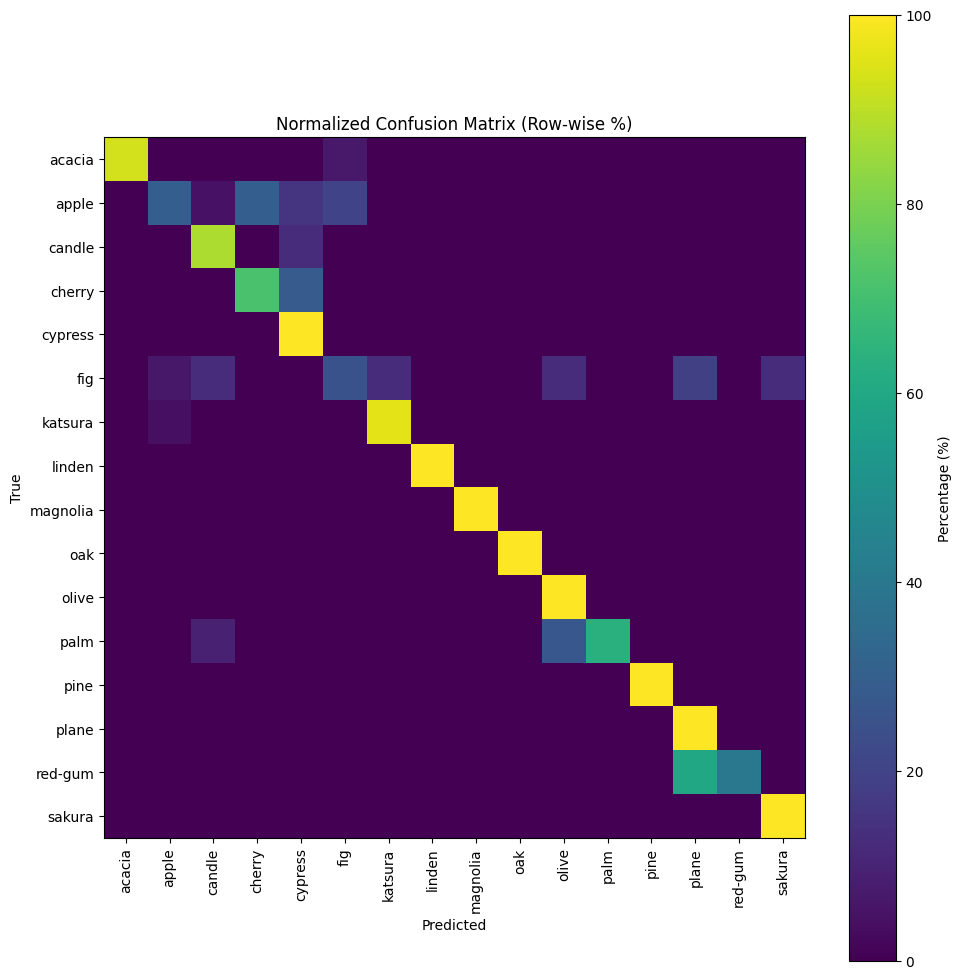

,acacia,apple,candle,cherry,cypress,fig,katsura,linden,magnolia,oak,olive,palm,pine,plane,red-gum,sakura
acacia,93.333333,0.00,0.000000,0.000000,0.000000,6.666667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0
apple,0.000000,30.00,5.000000,30.000000,15.000000,20.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0
candle,0.000000,0.00,87.500000,0.000000,12.500000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0
cherry,0.000000,0.00,0.000000,71.428571,28.571429,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0
cypress,0.000000,0.00,0.000000,0.000000,100.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0
fig,0.000000,6.25,12.500000,0.000000,0.000000,25.000000,12.5,0.0,0.0,0.0,12.500000,0.000000,0.0,18.75,0.0,12.5
katsura,0.000000,4.00,0.000000,0.000000,0.000000,0.000000,96.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0
linden,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,100.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0
magnolia,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,100.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0
oak,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,100.0,0.000000,0.000000,0.0,0.00,0.0,0.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

df_cm_norm = df_cm.div(df_cm.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 10))
plt.imshow(df_cm_norm.values)
plt.colorbar(label="Percentage (%)")

plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Row-wise %)")

plt.tight_layout()
plt.show()

df_cm_norm


In [20]:
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (tp + fp + fn)

metrics = pd.DataFrame({
    "TP": tp,
    "FP": fp,
    "FN": fn,
    "TN": tn,
}, index=class_names)

print("Per-class TP / FP / FN / TN:")
display(metrics)


Per-class TP / FP / FN / TN:


,TP,FP,FN,TN
acacia,14,0,1,241
apple,6,2,14,234
candle,28,4,4,220
cherry,10,6,4,236
cypress,32,11,0,213
fig,4,5,12,235
katsura,24,2,1,229
linden,6,0,0,250
magnolia,8,0,0,248
oak,8,0,0,248


In [21]:
metrics["precision"] = tp / (tp + fp + 1e-12)
metrics["recall"]    = tp / (tp + fn + 1e-12)
metrics["f1"]        = 2 * metrics["precision"] * metrics["recall"] / (
    metrics["precision"] + metrics["recall"] + 1e-12
)

display(metrics)


,TP,FP,FN,TN,precision,recall,f1
acacia,14,0,1,241,1.000000,0.933333,0.965517
apple,6,2,14,234,0.750000,0.300000,0.428571
candle,28,4,4,220,0.875000,0.875000,0.875000
cherry,10,6,4,236,0.625000,0.714286,0.666667
cypress,32,11,0,213,0.744186,1.000000,0.853333
fig,4,5,12,235,0.444444,0.250000,0.320000
katsura,24,2,1,229,0.923077,0.960000,0.941176
linden,6,0,0,250,1.000000,1.000000,1.000000
magnolia,8,0,0,248,1.000000,1.000000,1.000000
oak,8,0,0,248,1.000000,1.000000,1.000000


In [22]:
print("Total samples:", cm.sum())
print("Accuracy from CM:", tp.sum() / cm.sum())
print("Best val acc reported:", result["best_val_acc"])


Total samples: 256
Accuracy from CM: 0.80859375
Best val acc reported: 0.80859375
